In [2]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

In [3]:

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

In [4]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [6]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

## Now working in any point in year 2005


dir_1 = '../../../data_ARMOR/'
dir_2 = '../Vertical-prof/'
fl_n1 = 'ARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)

# Gulf Stream

## Amplitude of the Seasonal Cycle

    * For MLD and GPH

In [7]:
r = 'gul'
reg = Crops(r, c_armor)
reg = Masking(reg, reg.to[0,25])
#data_set = reg.where(reg.mask == 1)

In [8]:
r_min = reg.groupby('time.year').min(dim='time')
r_max = reg.groupby('time.year').max(dim='time')

amp_y = r_max - r_min
amp_mean = amp_y.mean(dim='year') 

In [9]:
min_y = amp_mean.mlotst.min(skipna=True).values
max_y = amp_mean.mlotst.max(skipna=True).values

min_yf = amp_mean.mlotst.where(amp_mean.mask == 1).min(skipna=True).values
max_yf = amp_mean.mlotst.where(amp_mean.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-pack

In [10]:
cm_levs = (min_y, max_y, 20)
cm_levsf = (min_yf, max_yf, 20)

### Full dataset 

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


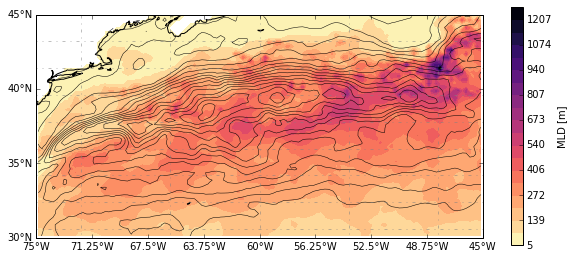

In [12]:
ax = Plot_2D(amp_mean, r, *cm_levs, t=None, cmap='magma_r', 
             ext='neither', cont_line=True, nlines=15)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-p2p-complete.png')

### Filtered dataset

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


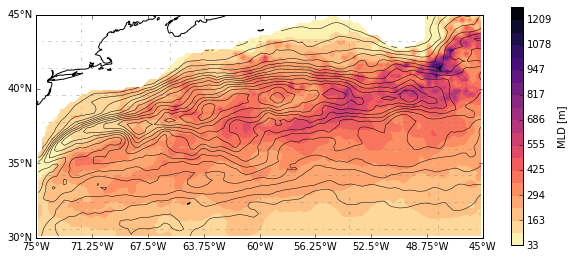

In [13]:
ax = Plot_2D(amp_mean.where(amp_mean.mask == 1), r, *cm_levsf, t=None, 
             cmap='magma_r', ext='neither', cont_line=True, nlines=15)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-p2p-filter.png')

## Mean

Here, calculating mean, for the Gulf Stream

In [14]:
mean_g = reg.mean(dim='time', skipna=True)

gmin_mn = mean_g.mlotst.min(skipna=True).values
gmax_mn = mean_g.mlotst.max(skipna=True).values

gmin_mnf = mean_g.mlotst.where(mean_g.mask == 1).min(skipna=True).values
gmax_mnf = mean_g.mlotst.where(mean_g.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [15]:
cm_levs = (gmin_mn, gmax_mn, 20)
cm_levsf = (gmin_mnf, gmax_mnf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


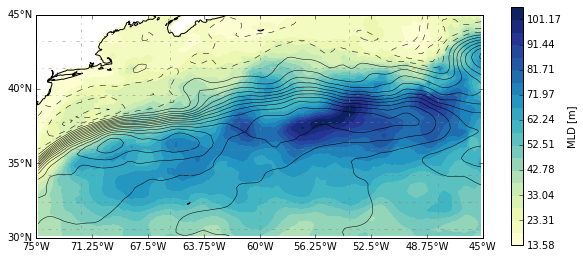

In [16]:
ax = Plot_2D(mean_g, r, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-mean-complete.png')

mean MLD and mean SSH

### Filtered dataset

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


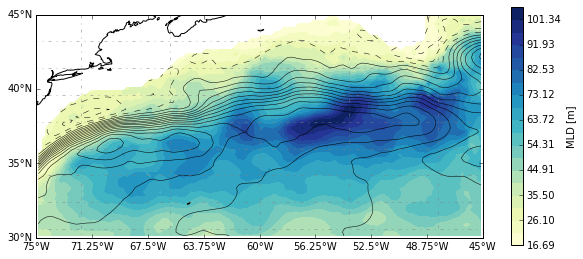

In [17]:
ax = Plot_2D(mean_g.where(mean_g.mask == 1), r, *cm_levsf, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-mean-filter.png')

## STD

Calculating the standar deviation for the Gulf Stream

In [18]:
std = reg.std(dim='time', skipna=True)

min_std = std.mlotst.min(skipna=True).values
max_std = std.mlotst.max(skipna=True).values

min_stdf = std.mlotst.where(std.mask == 1).min(skipna=True).values
max_stdf = std.mlotst.where(std.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [19]:
cm_levs = (min_std, max_std, 20)
cm_levsf = (min_stdf, max_stdf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


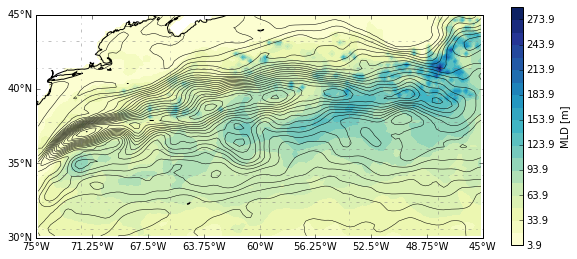

In [20]:
ax = Plot_2D(std, r, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-std-complete.png')

### Filtered dataset

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


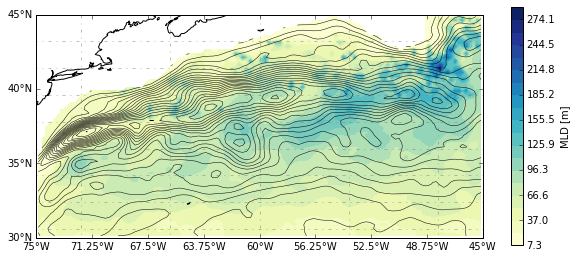

In [21]:
ax = Plot_2D(std.where(std.mask == 1), r, *cm_levsf, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-std-filter.png')

# North East

## Amplitude of the Seasonal Cycle

In [55]:
r2 = 'noe'
reg_n = Crops(r2, c_armor)
reg_n = Masking(reg_n, reg_n.to[0,25])

In [56]:
rn_min = reg_n.groupby('time.year').min(dim='time')
rn_max = reg_n.groupby('time.year').max(dim='time')

amp_yn = rn_max - rn_min
amp_mean_n = amp_yn.mean(dim='year') 

In [57]:
min_amp_n = amp_mean_n.mlotst.min(skipna=True).values
max_amp_n = amp_mean_n.mlotst.max(skipna=True).values

min_amp_nf = amp_mean_n.mlotst.where(amp_mean_n.mask == 1).min(skipna=True).values
max_amp_nf = amp_mean_n.mlotst.where(amp_mean_n.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-pack

In [58]:
cm_levs = (min_amp_n, max_amp_n, 20)
cm_levsf = (min_amp_nf, max_amp_nf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


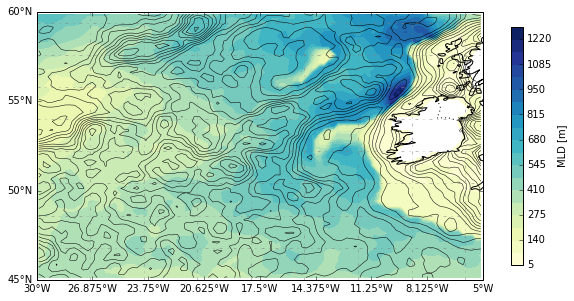

In [59]:
ax = Plot_2D(amp_mean_n, r2, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-p2p-complete.png')

### Filtered dataset

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


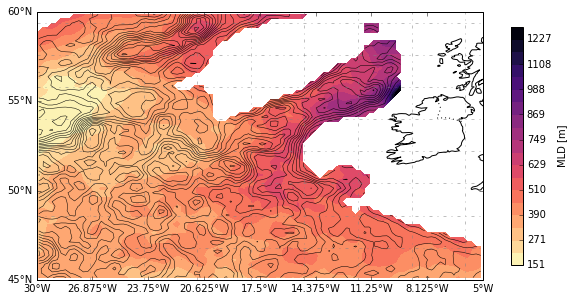

In [60]:
ax = Plot_2D(amp_mean_n.where(amp_mean_n.mask == 1), r2, *cm_levsf, t=None, 
             cmap='magma_r', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-p2p-filter.png')

## Mean

Here, calculating mean, for the North East region

In [28]:
mean_n = reg_n.mean(dim='time', skipna=True)

min_mn_n = mean_n.mlotst.min(skipna=True).values
max_mn_n = mean_n.mlotst.max(skipna=True).values

min_mn_nf = mean_n.mlotst.where(mean_n.mask == 1).min(skipna=True).values
max_mn_nf = mean_n.mlotst.where(mean_n.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [29]:
cm_levs = (min_mn_n, max_mn_n, 20)
cm_levsf = (min_mn_nf, max_mn_nf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


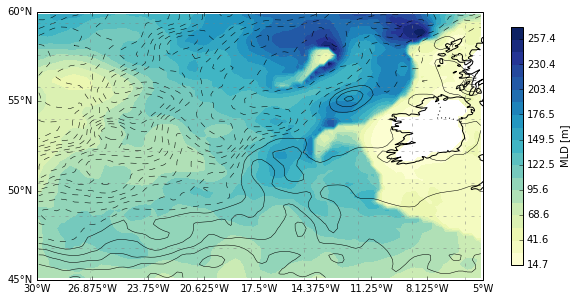

In [30]:
ax = Plot_2D(mean_n, r2, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-mean-complete.png')

### Filetered dataset

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


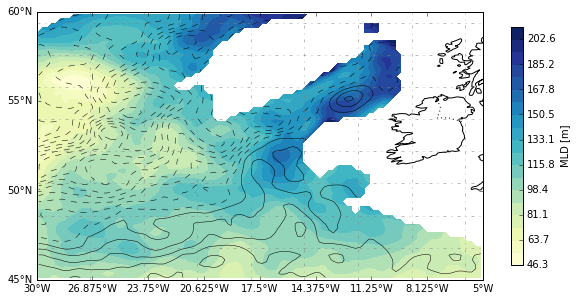

In [31]:
ax = Plot_2D(mean_n.where(mean_n.mask == 1), r2, *cm_levsf, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-mean-filter.png')

## STD

In [32]:
std_n = reg_n.std(dim='time', skipna=True)

min_std_n = std_n.mlotst.min(skipna=True).values
max_std_n = std_n.mlotst.max(skipna=True).values

min_std_nf = std_n.mlotst.where(std_n.mask == 1).min(skipna=True).values
max_std_nf = std_n.mlotst.where(std_n.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [33]:
cm_levs = (min_std_n, max_std_n, 20)
cm_levsf = (min_std_nf, max_std_nf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


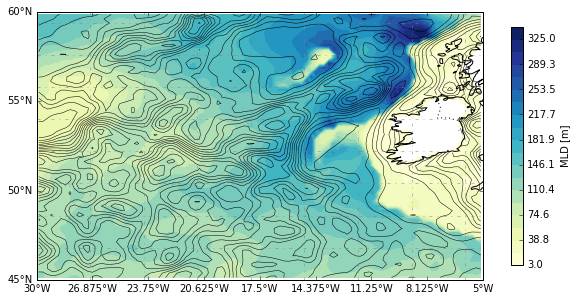

In [34]:
ax = Plot_2D(std_n, r2, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-std-complete.png')

#### Filtered dataset

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


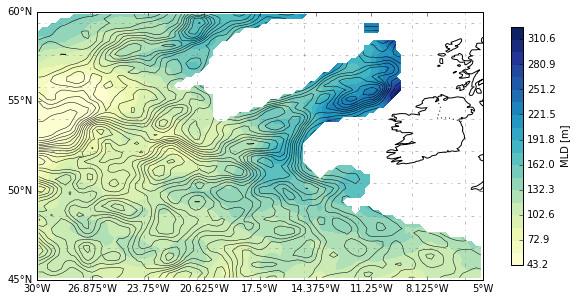

In [35]:
ax = Plot_2D(std_n.where(std_n.mask == 1), r2, *cm_levsf, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-std-filter.png')

# Labrador and Irminger Seas

## Amplitude of the Seasonal Cycle

    * For MLD and GPH

In [40]:
r3 = 'lab'
reg_l = Crops(r3, c_armor)
reg_l = Masking(reg_l, reg_l.to[0,25])

In [41]:
rl_min = reg_l.groupby('time.year').min(dim='time', skipna=True)
rl_max = reg_l.groupby('time.year').max(dim='time', skipna=True)

amp_yl = rl_max - rl_min
amp_mean_l = amp_yl.mean(dim='year') 

In [42]:
min_amp_l = amp_mean_l.mlotst.min(skipna=True).values
max_amp_l = amp_mean_l.mlotst.max(skipna=True).values

min_amp_lf = amp_mean_l.mlotst.where(amp_mean_l.mask == 1).min(skipna=True).values
max_amp_lf = amp_mean_l.mlotst.where(amp_mean_l.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-pack

In [43]:
cm_levs = (min_amp_l, max_amp_l, 20)
cm_levsf = (min_amp_lf, max_amp_lf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


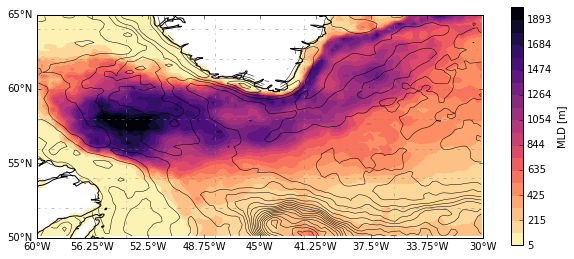

In [44]:
ax = Plot_2D(amp_mean_l, r3, *cm_levs, t=None, 
             cmap='magma_r', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-p2p-complete.png')

### Filtered dataset

/usr/local/lib/python3.5/dist-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


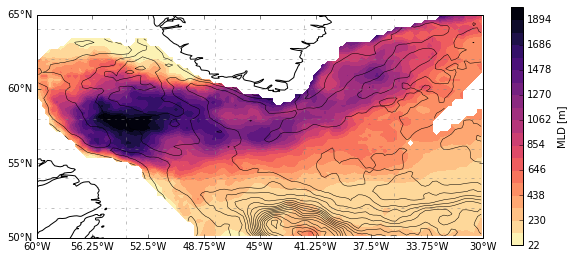

In [45]:
ax = Plot_2D(amp_mean_l.where(amp_mean_l.mask == 1), r3, *cm_levsf, t=None, 
             cmap='magma_r', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-p2p-filter.png')

## Mean

Here, calculating mean for the entire region of Labrador and Irminger seas

In [46]:
mean_l = reg_l.mean(dim='time', skipna=True)

min_mn_l = mean_l.mlotst.min(skipna=True).values
max_mn_l = mean_l.mlotst.max(skipna=True).values

min_mn_lf = mean_l.mlotst.where(mean_l.mask == 1).min(skipna=True).values
max_mn_lf = mean_l.mlotst.where(mean_l.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [47]:
cm_levs = (min_mn_l, max_mn_l, 20)
cm_levsf = (min_mn_lf, max_mn_lf, 20)

### Complete dataset

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


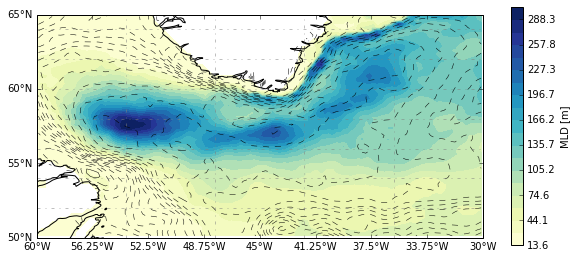

In [48]:
ax = Plot_2D(mean_l, r3, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-mean-complete.png')

### Filtered data

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


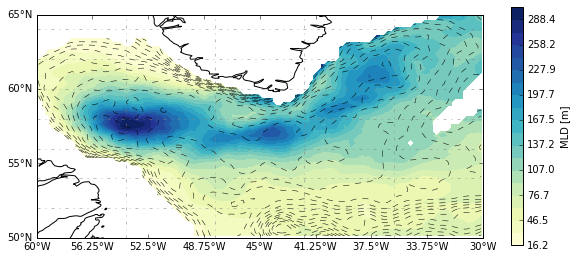

In [49]:
ax = Plot_2D(mean_l.where(mean_l.mask == 1), r3, *cm_levsf, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-mean-filter.png')

## Standar deviation

In [50]:
std_l = reg_l.std(dim='time', skipna=True)

min_std_l = std_l.mlotst.min(skipna=True).values
max_std_l = std_l.mlotst.max(skipna=True).values

min_std_lf = std_l.mlotst.where(std_l.mask == 1).min(skipna=True).values
max_std_lf = std_l.mlotst.where(std_l.mask == 1).max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [51]:
cm_levs = (min_std_l, max_std_l, 20)
cm_levsf = (min_std_lf, max_std_lf, 20)

### Complete

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


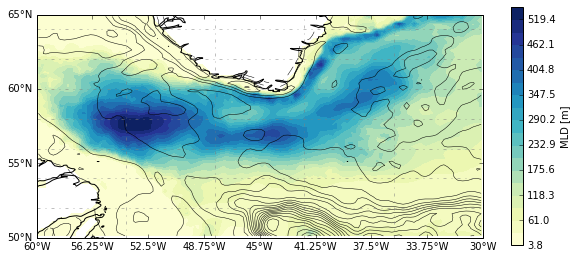

In [52]:
ax = Plot_2D(std_l, r3, *cm_levs, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-std-complete.png')

### Filtered

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


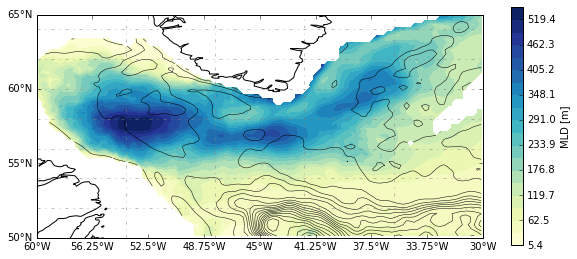

In [53]:
ax = Plot_2D(std_l.where(std_l.mask == 1), r3, *cm_levsf, t=None, 
             cmap='YlGnBu', ext='neither', cont_line=True, nlines=20)
plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-std-filter.png')